In [7]:
import pandas as pd
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from sklearn.linear_model import LinearRegression

PATH = '../DATA/Brugge/'

In [2]:
# функция поиска коэффициентов k и b уравнения k*x + b
# на вход даем дата-фрейм с исх данными
# на выходе коэффициенты 

def linear_regressor(df):
    alf_PS = df.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
    Poro = df.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(alf_PS, Poro)  # perform linear regression

    # The coefficients of linear gerression
    k = linear_regressor.coef_
    b = linear_regressor.intercept_

    return (k, b)

In [3]:
#функция поиска значений сигмы для определения доверительного коридора неопределенности
#на вход даем дата фрейм и требуемое количество сигм
# на выходе получаем нижнюю и верхнюю оценку сигмы

def sigma_counter(df, how_many_sigmas = 1):
    #print(df.head())
    return (df['Flat'].mean() - how_many_sigmas * df['Flat'].std(), df['Flat'].mean() + how_many_sigmas * df['Flat'].std())

In [4]:
''' функция поиска граничных значений неопределенностей для проведения оптимизационного процесса.
на вход подаем данные

input:
    file_name - имя файла с данными, по которым надо найти границу
    outer_limit - количество сигм для внешней границы неопр
    inner_limit - количество сигм для внутренней границы неопр
    if_ln_0 - нужно ли переводить первый столбик датафрейма в логарифм
    if_ln_1 - нужно ли переводить второй столбик датафрейма в логарифм

output: 
    файл с параметрами внешней границы
    файл с параметрами внутренней границы
    картинка с границами

'''

def Bourders_initializer(file_name, outer_limit = 3, inner_limit = 1, if_ln_0 = False, if_ln_1 = False):
    df = pd.read_excel(PATH + file_name) #считываю инф с файла

    if if_ln_0:
        df.iloc[:, 0] = np.log(df.iloc[:, 0])

    if if_ln_1:
        df.iloc[:, 1] = np.log(df.iloc[:, 1])
        
    X_max = df.iloc[:, 0].max() #макс значение по Х
    X_min = df.iloc[:, 0].min() #мин значение по Х

    k = linear_regressor(df)[0] # k of k*x + b
    b = linear_regressor(df)[1] # b of k*x + b

    #delete trend from data
    df['Flat'] = pd.Series(np.nan, index=df.index)
    for row in df.iterrows():
        row[1]['Flat']= row[1][1] - (k*row[1][0] + b)
    
    #------------------------------------расчет внешних границ-----------------------------    
    gamma_min = k * X_min + b + sigma_counter(df, outer_limit)[0]
    gamma_max = k * X_min + b + sigma_counter(df, outer_limit)[1]
    beta_min = k * X_max + b + sigma_counter(df, outer_limit)[0]
    beta_max = k * X_max + b + sigma_counter(df, outer_limit)[1]

    #внешние границы неопределенности
    file = open(PATH + file_name + "_outer_limits.txt","w") 

    L = [df.columns[0]+'_min\t', str(X_min), '\n',
         df.columns[0]+'_max\t', str(X_max), '\n',
         'gamma_min\t', str(gamma_min.item()), '\n',
         'gamma_max\t', str(gamma_max.item()), '\n',
         'beta_min\t', str(beta_min.item()), '\n',
         'beta_max\t', str(beta_max.item()), '\n',] 

    file.writelines(L) 

    file.close() #to change file access modes 

    x_out_down, y_out_down = [X_min, X_max], [gamma_min.item(),beta_min.item()]
    x_out_up, y_out_up = [X_min, X_max], [gamma_max.item(),beta_max.item()]

    #------------------------------------разброса среднего треугольника-----------------------------
    gamma_tri_min = (gamma_min + gamma_min + gamma_max)/3
    gamma_tri_max = (gamma_min + gamma_max + gamma_max)/3
    beta_tri_min = (beta_min + beta_min + beta_max)/3
    beta_tri_max = (beta_min + beta_max + beta_max)/3
    
    x_tri_down, y_tri_down = [X_min, X_max], [gamma_tri_min.item(),beta_tri_min.item()]
    x_tri_up, y_tri_up = [X_min, X_max], [gamma_tri_max.item(),beta_tri_max.item()]
    
    #------------------------------------расчет внутренних границ-----------------------------    
    gamma_min = k * X_min + b + sigma_counter(df, inner_limit)[0]
    gamma_max = k * X_min + b + sigma_counter(df, inner_limit)[1]
    beta_min = k * X_max + b + sigma_counter(df, inner_limit)[0]
    beta_max = k * X_max + b + sigma_counter(df, inner_limit)[1]

    #внутренние границы неопределенности
    file = open(PATH + file_name + "_inner_limits.txt","w") 

    L = [df.columns[0]+'_min\t', str(X_min), '\n',
         df.columns[0]+'_max\t', str(X_max), '\n',
         'gamma_min\t', str(gamma_min.item()), '\n',
         'gamma_max\t', str(gamma_max.item()), '\n',
         'beta_min\t', str(beta_min.item()), '\n',
         'beta_max\t', str(beta_max.item()), '\n',] 

    file.writelines(L) 

    file.close() #to change file access modes 

    x_in_down, y_in_down = [X_min, X_max], [gamma_min.item(),beta_min.item()]
    x_in_up, y_in_up = [X_min, X_max], [gamma_max.item(),beta_max.item()]
    
    #------------------------------------разброса среднего треугольника-----------------------------
    gamma_tri_min = (gamma_min + gamma_min + gamma_max)/3
    gamma_trin_max = (gamma_min + gamma_max + gamma_max)/3
    beta_tri_min = (beta_min + beta_min + beta_max)/3
    beta_tri_max = (beta_min + beta_max + beta_max)/3
    
    draw_plot(file_name, df, x_in_down, y_in_down, x_in_up, y_in_up, x_out_down, y_out_down, x_out_up, y_out_up, x_tri_down, x_tri_up, y_tri_down, y_tri_up) 

In [5]:
def draw_plot(file_name, df, x_in_down, y_in_down, x_in_up, y_in_up, x_out_down, y_out_down, x_out_up, y_out_up, x_tri_down, x_tri_up, y_tri_down, y_tri_up):
    df.plot(x=str(df.columns[0]), y=str(df.columns[1]), style='o', markersize = 3, label=file_name)

    line1, = plt.plot(x_in_down, y_in_down, marker='o', label='inner_down', color='C2')
    line2, = plt.plot(x_in_up, y_in_up, marker='o', label='inner_up', color='C2')
    line3, = plt.plot(x_out_down, y_out_down, marker='o', label='outer_down', color='C1')
    line4, = plt.plot(x_out_up, y_out_up, marker='o', label='outer_up', color='C1')
    #triangle_mean
    line5, = plt.plot(x_tri_down, y_tri_down, marker='o', label='tri_mean_down', color='C3')
    line6, = plt.plot(x_tri_up, y_tri_up, marker='o', label='tri_mean_up', color='C3')
    
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2), line2: HandlerLine2D(numpoints=2), line3: HandlerLine2D(numpoints=2), line4: HandlerLine2D(numpoints=2)})


    # inner_down text
    plt.text(x_in_down[0], y_in_down[0], str(round(x_in_down[0], 3)) + str(';') +str(round(y_in_down[0], 3)))
    plt.text(x_in_down[1], y_in_down[1], str(round(x_in_down[1], 3)) + str(';') +str(round(y_in_down[1], 3)), horizontalalignment='right')

    # inner_up text
    plt.text(x_in_up[0], y_in_up[0], str(round(x_in_up[0], 3)) + str(';') +str(round(y_in_up[0], 3)))
    plt.text(x_in_up[1], y_in_up[1], str(round(x_in_up[1], 3)) + str(';') +str(round(y_in_up[1], 3)), horizontalalignment='right')

    # out_down text
    plt.text(x_out_down[0], y_out_down[0], str(round(x_out_down[0], 3)) + str(';') +str(round(y_out_down[0], 3)))
    plt.text(x_out_down[1], y_out_down[1], str(round(x_out_down[1], 3)) + str(';') +str(round(y_out_down[1], 3)), horizontalalignment='right')

    # out_up text
    plt.text(x_out_up[0], y_out_up[0], str(round(x_out_up[0], 3)) + str(';') +str(round(y_out_up[0], 3)))
    plt.text(x_out_up[1], y_out_up[1], str(round(x_out_up[1], 3)) + str(';') +str(round(y_out_up[1], 3)), horizontalalignment='right')

    # tri_down text
    plt.text(x_tri_down[0], y_tri_down[0], str(round(x_tri_down[0], 3)) + str(';') +str(round(y_tri_down[0], 3)))
    plt.text(x_tri_down[1], y_tri_down[1], str(round(x_tri_down[1], 3)) + str(';') +str(round(y_tri_down[1], 3)), horizontalalignment='right')

    # tri_up text
    plt.text(x_tri_up[0], y_tri_up[0], str(round(x_tri_up[0], 3)) + str(';') +str(round(y_tri_up[0], 3)))
    plt.text(x_tri_up[1], y_tri_up[1], str(round(x_tri_up[1], 3)) + str(';') +str(round(y_tri_up[1], 3)), horizontalalignment='right')

    #plt.show()
    plt.savefig(PATH + file_name + '_plot.png')
    


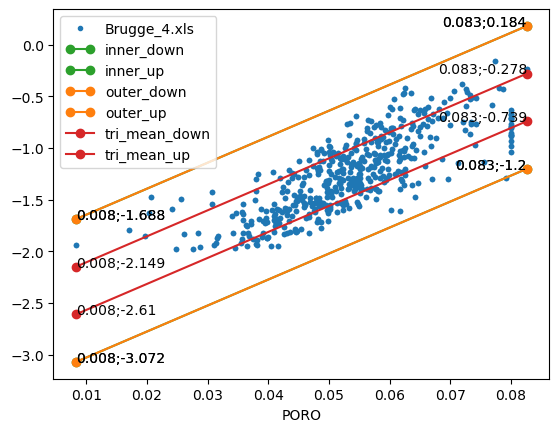

In [25]:
Bourders_initializer('Brugge_4.xls', outer_limit = 3, inner_limit = 3, if_ln_0 = False, if_ln_1 = False)
#Bourders_initializer('Poro-Perm.xlsx', outer_limit = 3, inner_limit = 2, if_ln_0 = False, if_ln_1 = True)